In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm

import os

/tmp/ipykernel_229728/2402371928.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-29 10:12:30.745398: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 10:12:30.784026: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 10:1

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water, data_ice, data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

df=data_all.copy()
#data_all=hf.add_MSI_noise(data_all,channel_labels)

##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

X_labels_COT= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle','COT']

X_labels_COT_cat= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle','Thin','Mid','Thick']


#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels_one=['Clear_B12']

In [4]:


X_truth=df_truth[X_labels]


#df=hf.normalise_input_df(data_all,X_labels)
#df=hf.add_noise(df,X_labels,sigma=0.001)

#Add categorical COT
df['COT_cat']=0
df.loc[(df['COT']>0.0)&(df['COT']<=3.6),['COT_cat']]=1
df.loc[(df['COT']>3.6) & (df['COT']<=23),['COT_cat']]=2
df.loc[df['COT']>23,['COT_cat']]=3

df.loc[df['COT_cat']==1,'Thin']=1
df.loc[df['COT_cat']!=1,'Thin']=0

df.loc[df['COT_cat']==2,'Mid']=1
df.loc[df['COT_cat']!=2,'Mid']=0

df.loc[df['COT_cat']==3,'Thick']=1
df.loc[df['COT_cat']!=3,'Thick']=0

X=df[X_labels]
X_COT=df[X_labels_COT]
X_COT_cat=df[X_labels_COT_cat]
y_one=df[y_labels_one]

#X_train, X_test, y_train, y_test=train_test_split(X,y_one,test_size=0.05)
#X_train_COT, X_test_COT, y_train_COT, y_test_COT=train_test_split(X_COT,y_one,test_size=0.05)

X_train_df, X_test_df, y_train, y_test=train_test_split(df,y_one,test_size=0.05)

X_train_COT=X_train_df[X_labels_COT]
X_test_COT=X_test_df[X_labels_COT]

X_train_COT_cat=X_train_df[X_labels_COT_cat]
X_test_COT_cat=X_test_df[X_labels_COT_cat]

X_train=X_train_df[X_labels]
X_test=X_test_df[X_labels]


#indexes_training_data=X_train.index
#indexes_test_data=X_test.index

#X_train_COT=X_COT.iloc[indexes_training_data]
#X_test_COT=X_COT.iloc[indexes_test_data]


In [5]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

#val_size=0.05
#validation_indices_COT=np.array(random.sample(range(len(X_train_COT['Cloud_B02'])), int(len(X_train_COT['Cloud_B02'])*val_size)))
#train_indices_COT=[i for i in range(len(X_train_COT['Cloud_B02'])) if np.any(validation_indices_COT==i)==False]


Best model out of total max epochs found at epoch 277


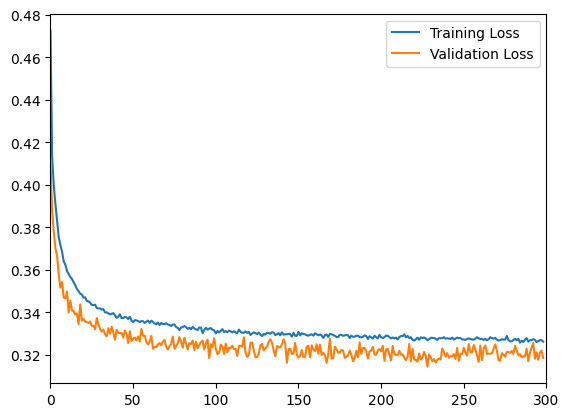

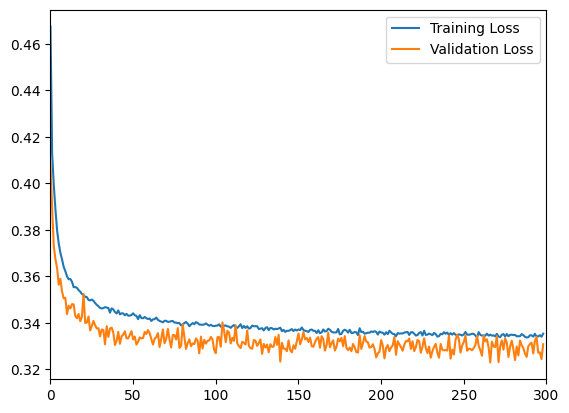

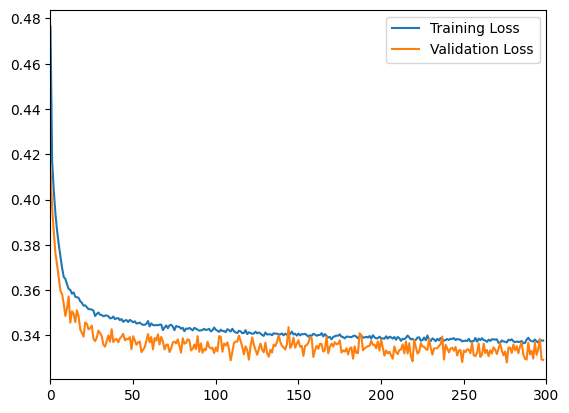

In [6]:
quantiles=np.array([0.1,0.5,0.9])
batch_size=500
save=False

nepochs=300
model_COT=QuantileNetwork(quantiles=quantiles)
model_cat=QuantileNetwork(quantiles=quantiles)
model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
n_nodes_one=64
sequence_all=lambda: nn.Sequential(
    nn.Linear(len(X_labels_COT),n_nodes_one),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_one,n_nodes_one),
    nn.ReLU(),
    nn.Linear(n_nodes_one, len(quantiles)*len(y_labels_one)) #Output dimesion is number of quantiles times number of target variables
)

sequence_cat=lambda: nn.Sequential(
    nn.Linear(len(X_labels_COT_cat),n_nodes_one),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_one,n_nodes_one),
    nn.ReLU(),
    nn.Linear(n_nodes_one, len(quantiles)*len(y_labels_one)) #Output dimesion is number of quantiles times number of target variables
)

sequence_one=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes_one),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_one,n_nodes_one),
    nn.ReLU(),
    nn.Linear(n_nodes_one, len(quantiles)*len(y_labels_one)) #Output dimesion is number of quantiles times number of target variables
)

model_COT.fit(X_train_COT.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence_all(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_COT_in_X/COT',model=model_COT,X_test=X_test_COT,y_test=y_test)
    print("Model all saved...")

model_cat.fit(X_train_COT_cat.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence_cat(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_COT_in_X/COT_cat',model=model_cat,X_test=X_test_COT_cat,y_test=y_test)
    print("Model all saved...")

model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence_one(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_COT_in_X/No_COT',model=model,X_test=X_test,y_test=y_test)
    print("Model one saved...")


## Load trained models and Visualise

In [43]:
#Load models
model_COT,X_test_COT,y_test=hf.load_model_and_test_data('pytorch_models/test_COT_in_X/COT')
model_cat,X_test_cat,y_test=hf.load_model_and_test_data('pytorch_models/test_COT_in_X/COT_cat')
model,X_test,y_test=hf.load_model_and_test_data('pytorch_models/test_COT_in_X/No_COT')


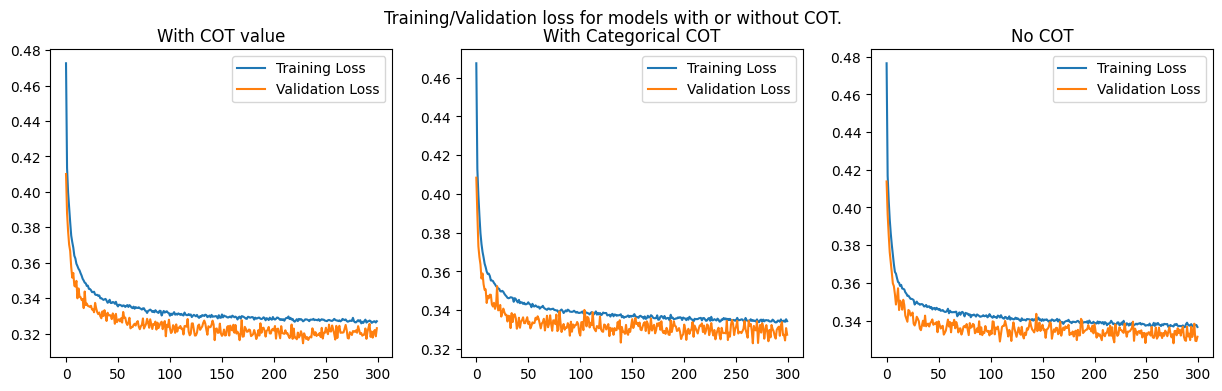

In [44]:
plt.rcParams["figure.figsize"] = [15, 4]
fig, ax =plt.subplots(nrows=1,ncols=3)
fig.suptitle("Training/Validation loss for models with or without COT.")

ax[0].plot(model_COT.train_loss.data.cpu().numpy())
ax[0].plot(model_COT.val_loss.data.cpu().numpy())
ax[0].set_title("With COT value")
ax[0].legend(['Training Loss','Validation Loss'])

ax[1].plot(model_cat.train_loss.data.cpu().numpy())
ax[1].plot(model_cat.val_loss.data.cpu().numpy())
ax[1].set_title("With Categorical COT")
ax[1].legend(['Training Loss','Validation Loss'])

ax[2].plot(model.train_loss.data.cpu().numpy())
ax[2].plot(model.val_loss.data.cpu().numpy())
ax[2].set_title("No COT")
ax[2].legend(['Training Loss','Validation Loss'])

In [58]:
cot_limit=True
cot_limit_val=3.6
if cot_limit:
    df_test=df.iloc[X_test.index]

    X_test_COT=df_test[df_test['COT']<cot_limit_val][X_labels_COT]
    X_test_cat=df_test[df_test['COT']<cot_limit_val][X_labels_COT_cat]
    X_test=df_test[df_test['COT']<cot_limit_val][X_labels]

    indexes=X_test.index

    y_test=df.iloc[indexes][y_labels_one]

In [59]:
#Make predictions
y_preds_COT=model_COT.predict(X_test_COT.to_numpy())
y_preds_COT=y_preds_COT[:,0,:]

y_preds_cat=model_cat.predict(X_test_cat.to_numpy())
y_preds_cat=y_preds_cat[:,0,:]

y_preds=model.predict(X_test.to_numpy())
y_preds=y_preds[:,0,:]



In [60]:
## Calculate residuals
y_COT=y_test.to_numpy()[:,0]
res_COT=y_COT-y_preds_COT[:,1]

y_cat=y_test.to_numpy()[:,0]
res_cat=y_cat-y_preds_cat[:,1]

y=y_test.to_numpy()[:,0]
res=y-y_preds[:,1]

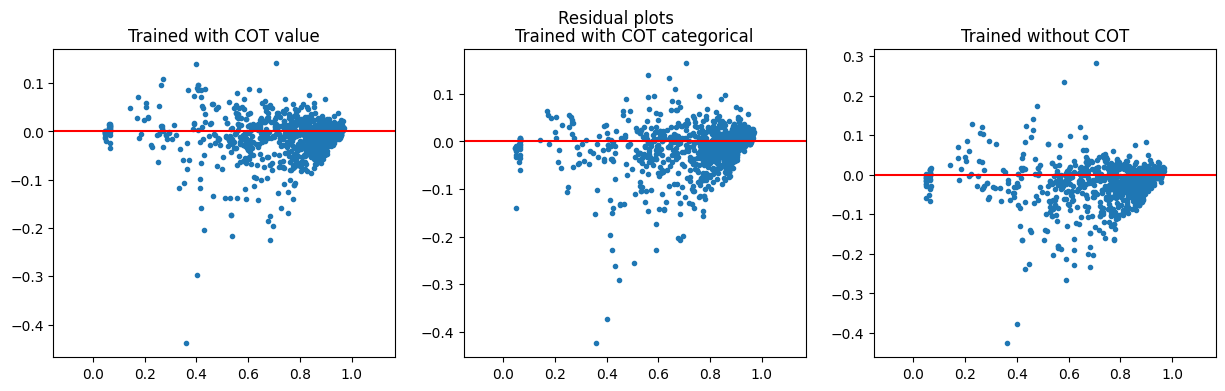

In [71]:
#Plot residuals
fig, ax =plt.subplots(nrows=1,ncols=3)
fig.suptitle("Residual plots")

ax[0].plot(y_COT,res_COT,'.')
ax[0].set_title("Trained with COT value")
ax[0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0].set_xlim((np.min(y_COT)-0.2,np.max(y_COT)+0.2))

ax[1].plot(y_cat,res_cat,'.')
ax[1].set_title("Trained with COT categorical")
ax[1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1].set_xlim((np.min(y_cat)-0.2,np.max(y_cat)+0.2))

ax[2].plot(y,res,'.')
ax[2].set_title("Trained without COT")
ax[2].hlines(0,xmin=-1,xmax=10,colors='r')
ax[2].set_xlim((np.min(y)-0.2,np.max(y)+0.2))

plt.show()


In [62]:
r2_COT=r2_score(y_COT,y_preds_COT[:,1])
r2_cat=r2_score(y_cat,y_preds_cat[:,1])
r2=r2_score(y,y_preds[:,1])

mse_COT=mean_squared_error(y_COT,y_preds_COT[:,1])
mse_cat=mean_squared_error(y_cat,y_preds_cat[:,1])
mse_one=mean_squared_error(y,y_preds[:,1])

print("R2 score, with COT value: "+str(r2_COT))
print("R2 score, with COT categorical: "+str(r2_cat))
print("R2 score, without COT: "+str(r2))
print(" ")
print("MSE score, with COT value: "+str(mse_COT))
print("MSE score, with COT categorical: "+str(mse_cat))
print("MSE score, without COT: "+str(mse_one))


R2 score, with COT value: 0.9658924133285445
R2 score, with COT categorical: 0.9549493536402804
R2 score, without COT: 0.9454309914691981
 
MSE score, with COT value: 0.001197427226297087
MSE score, with COT categorical: 0.0015816091309255895
MSE score, without COT: 0.0019157736710086572


In [63]:
samples=len(X_test)
#samples=100

/tmp/ipykernel_229728/2926107702.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[0].errorbar(x=y_samps_sort_COT
/tmp/ipykernel_229728/2926107702.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[1].errorbar(x=y_samps_sort_cat
/tmp/ipykernel_229728/2926107702.py:58: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[2].errorbar(x=y_samps_sort


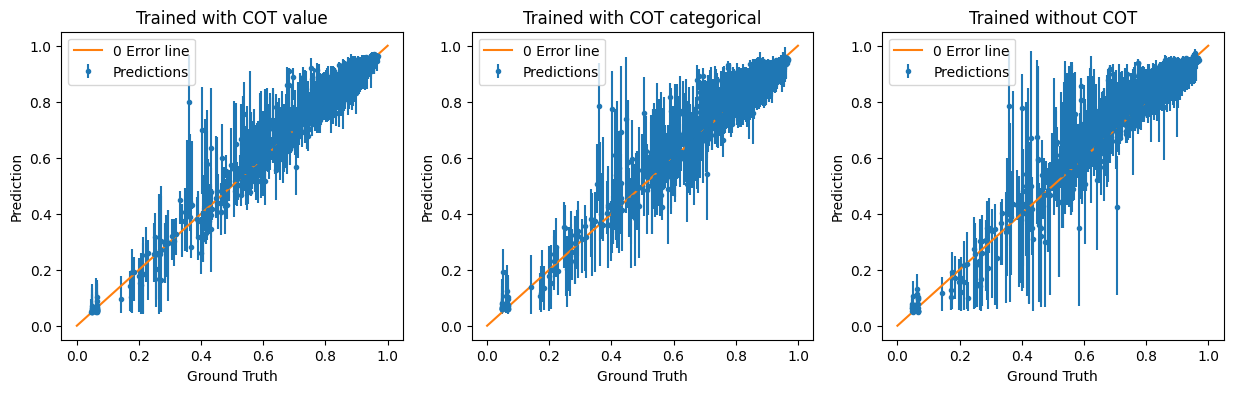

In [64]:

#Get ground truth y, all model
y_samps_COT=y_COT[0:samples]
sort_ind_COT=np.argsort(y_samps_COT)
y_samps_sort_COT=y_samps_COT[sort_ind_COT]

#Get y predictions, all model
y_pred_samps_COT=y_preds_COT[0:samples,:]
y_pred_samps_sort_COT=y_pred_samps_COT[sort_ind_COT,:]

#Get ground truth y, all model
y_samps_cat=y_COT[0:samples]
sort_ind_cat=np.argsort(y_samps_cat)
y_samps_sort_cat=y_samps_cat[sort_ind_cat]

#Get y predictions, all model
y_pred_samps_cat=y_preds_cat[0:samples,:]
y_pred_samps_sort_cat=y_pred_samps_cat[sort_ind_cat,:]

#Get ground truth y, one model
y_samps=y[0:samples]
sort_ind=np.argsort(y_samps)
y_samps_sort=y_samps[sort_ind]

#Get y predictions, one model
y_pred_samps=y_preds[0:samples,:]
y_pred_samps_sort=y_pred_samps[sort_ind,:]


#plt.plot(y_plot_sort,'.')
fig,ax=plt.subplots(nrows=1,ncols=3)
ax[0].errorbar(x=y_samps_sort_COT
             ,y=y_pred_samps_sort_COT[:,1],
             yerr=[np.abs(y_pred_samps_sort_COT[:,1]-y_pred_samps_sort_COT[:,0]),
                   np.abs(y_pred_samps_sort_COT[:,1]-y_pred_samps_sort_COT[:,2])],
                    marker='.',fmt='.')
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
ax[0].plot(line,line)
ax[0].legend(['0 Error line','Predictions'])
ax[0].set_xlabel("Ground Truth")
ax[0].set_ylabel("Prediction")
ax[0].set_title("Trained with COT value")


ax[1].errorbar(x=y_samps_sort_cat
             ,y=y_pred_samps_sort_cat[:,1],
             yerr=[np.abs(y_pred_samps_sort_cat[:,1]-y_pred_samps_sort_cat[:,0]),
                   np.abs(y_pred_samps_sort_cat[:,1]-y_pred_samps_sort_cat[:,2])],
                    marker='.',fmt='.')
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
ax[1].plot(line,line)
ax[1].legend(['0 Error line','Predictions'])
ax[1].set_xlabel("Ground Truth")
ax[1].set_ylabel("Prediction")
ax[1].set_title("Trained with COT categorical")

ax[2].errorbar(x=y_samps_sort
             ,y=y_pred_samps_sort[:,1],
             yerr=[np.abs(y_pred_samps_sort[:,1]-y_pred_samps_sort[:,0]),
                   np.abs(y_pred_samps_sort[:,1]-y_pred_samps_sort[:,2])],
                    marker='.',fmt='.')
ax[2].plot(line,line)
ax[2].legend(['0 Error line','Predictions'])
ax[2].set_xlabel("Ground Truth")
ax[2].set_ylabel("Prediction")
ax[2].set_title("Trained without COT")

plt.show()

/tmp/ipykernel_229728/437738755.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[0].errorbar(x=np.linspace(0,samples,samples)
/tmp/ipykernel_229728/437738755.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[1].errorbar(x=np.linspace(0,samples,samples)
/tmp/ipykernel_229728/437738755.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[2].errorbar(x=np.linspace(0,samples,samples)


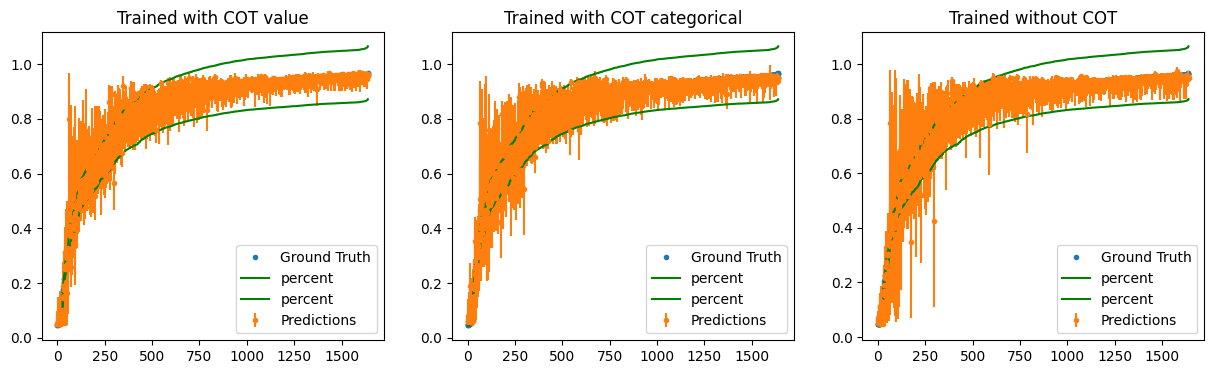

In [65]:

fig,ax =plt.subplots(nrows=1,ncols=3)

ax[0].plot(y_samps_sort_COT,'.',label='Ground Truth')
ax[0].errorbar(x=np.linspace(0,samples,samples)
             ,y=y_pred_samps_sort_COT[:,1],
             yerr=[np.abs(y_pred_samps_sort_COT[:,1]-y_pred_samps_sort_COT[:,0]),
                   np.abs(y_pred_samps_sort_COT[:,1]-y_pred_samps_sort_COT[:,2])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
ax[0].plot(y_samps_sort_COT-y_samps_sort_COT*percent,'g',label='percent')
ax[0].plot(y_samps_sort_COT+y_samps_sort_COT*percent,'g',label='percent')
#ax[0].legend(['Ground truth',str(percent*100)+' percent from ground','.','Predictions'])
ax[0].legend()
ax[0].set_title("Trained with COT value")


ax[1].plot(y_samps_sort_cat,'.',label='Ground Truth')
ax[1].errorbar(x=np.linspace(0,samples,samples)
             ,y=y_pred_samps_sort_cat[:,1],
             yerr=[np.abs(y_pred_samps_sort_cat[:,1]-y_pred_samps_sort_cat[:,0]),
                   np.abs(y_pred_samps_sort_cat[:,1]-y_pred_samps_sort_cat[:,2])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
ax[1].plot(y_samps_sort_cat-y_samps_sort_cat*percent,'g',label='percent')
ax[1].plot(y_samps_sort_cat+y_samps_sort_cat*percent,'g',label='percent')
#ax[0].legend(['Ground truth',str(percent*100)+' percent from ground','.','Predictions'])
ax[1].legend()
ax[1].set_title("Trained with COT categorical")


ax[2].plot(y_samps_sort,'.',label='Ground Truth')
ax[2].errorbar(x=np.linspace(0,samples,samples)
             ,y=y_pred_samps_sort[:,1],
             yerr=[np.abs(y_pred_samps_sort[:,1]-y_pred_samps_sort[:,0]),
                   np.abs(y_pred_samps_sort[:,1]-y_pred_samps_sort[:,2])],
                    marker='.',fmt='.',label='Predictions')

ax[2].plot(y_samps_sort-y_samps_sort*percent,'g',label='percent')
ax[2].plot(y_samps_sort+y_samps_sort*percent,'g',label='percent')
ax[2].legend()
ax[2].set_title("Trained without COT")
#plt.plot(cloudy_sort,'.')
#plt.legend(['Ground truth','Cloudy signal','prediction'])
plt.show()

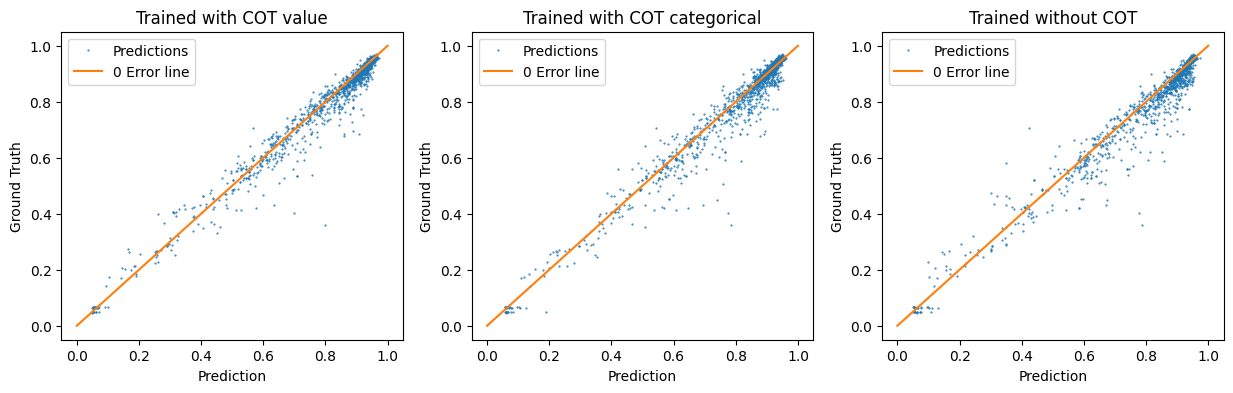

In [66]:
#plt.plot(y_plot_sort,'.')
fig,ax=plt.subplots(nrows=1,ncols=3)
ax[0].plot(y_pred_samps_sort_COT[:,1],y_samps_sort_COT,'.',markersize=1)
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
ax[0].plot(line,line)
ax[0].legend(['Predictions','0 Error line'])
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Ground Truth")
ax[0].set_title("Trained with COT value")


ax[1].plot(y_pred_samps_sort_cat[:,1],y_samps_sort_cat,'.',markersize=1)
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
ax[1].plot(line,line)
ax[1].legend(['Predictions','0 Error line'])
ax[1].set_xlabel("Prediction")
ax[1].set_ylabel("Ground Truth")
ax[1].set_title("Trained with COT categorical")


ax[2].plot(y_pred_samps_sort[:,1],y_samps_sort,'.',markersize=1)
ax[2].plot(line,line)
ax[2].legend(['Predictions','0 Error line'])
ax[2].set_xlabel("Prediction")
ax[2].set_ylabel("Ground Truth")
ax[2].set_title("Trained without COT")

plt.show()

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Trained without COT')

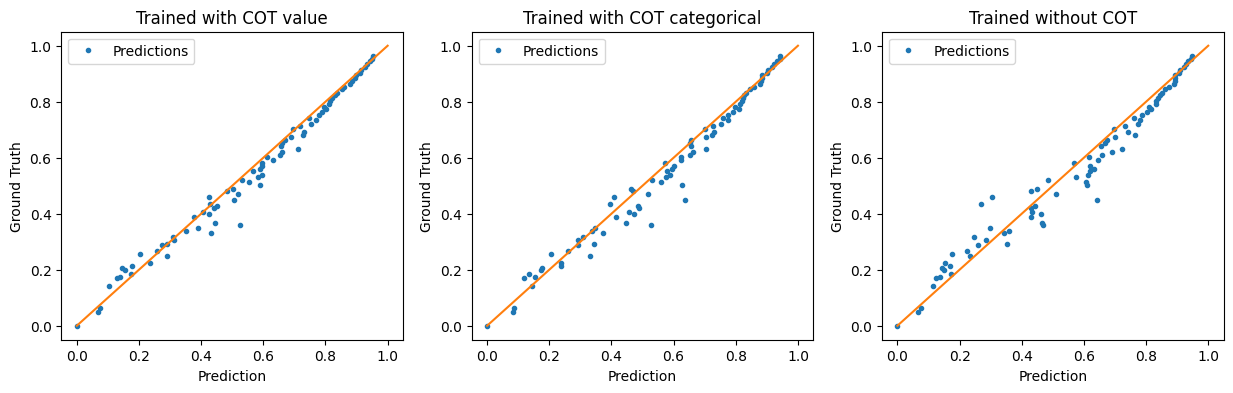

In [67]:
bins=np.linspace(0,1,100)
freq_true_COT=np.zeros(len(bins))
freq_pred_COT=np.zeros(len(bins))
for i,edge in enumerate(bins):
    if i!=0:
        indices=(y_samps_sort_COT>bins[i-1])&(y_samps_sort_COT<=edge)
        mean_bin_true=np.mean(y_samps_sort_COT[indices])
        mean_bin_pred=np.mean(y_pred_samps_sort_COT[indices])
        
        freq_true_COT[i]=mean_bin_true
        freq_pred_COT[i]=mean_bin_pred

freq_true_cat=np.zeros(len(bins))
freq_pred_cat=np.zeros(len(bins))
for i,edge in enumerate(bins):
    if i!=0:
        indices=(y_samps_sort_cat>bins[i-1])&(y_samps_sort_cat<=edge)
        mean_bin_true=np.mean(y_samps_sort_cat[indices])
        mean_bin_pred=np.mean(y_pred_samps_sort_cat[indices])
        
        freq_true_cat[i]=mean_bin_true
        freq_pred_cat[i]=mean_bin_pred



freq_true=np.zeros(len(bins))
freq_pred=np.zeros(len(bins))
for i,edge in enumerate(bins):
    if i!=0:
        indices=(y_samps_sort>bins[i-1])&(y_samps_sort<=edge)
        mean_bin_true=np.mean(y_samps_sort[indices])
        mean_bin_pred=np.mean(y_pred_samps_sort[indices])
        
        freq_true[i]=mean_bin_true
        freq_pred[i]=mean_bin_pred


#plt.plot(y_plot_sort,'.')
fig,ax=plt.subplots(nrows=1,ncols=3)
ax[0].plot(freq_pred_COT,freq_true_COT,'.')
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
ax[0].plot(line,line)
ax[0].legend(['Predictions'])
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Ground Truth")
ax[0].set_title("Trained with COT value")

ax[1].plot(freq_pred_cat,freq_true_cat,'.')
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
ax[1].plot(line,line)
ax[1].legend(['Predictions'])
ax[1].set_xlabel("Prediction")
ax[1].set_ylabel("Ground Truth")
ax[1].set_title("Trained with COT categorical")


ax[2].plot(freq_pred,freq_true,'.')
ax[2].plot(line,line)
ax[2].legend(['Predictions'])
ax[2].set_xlabel("Prediction")
ax[2].set_ylabel("Ground Truth")
ax[2].set_title("Trained without COT")

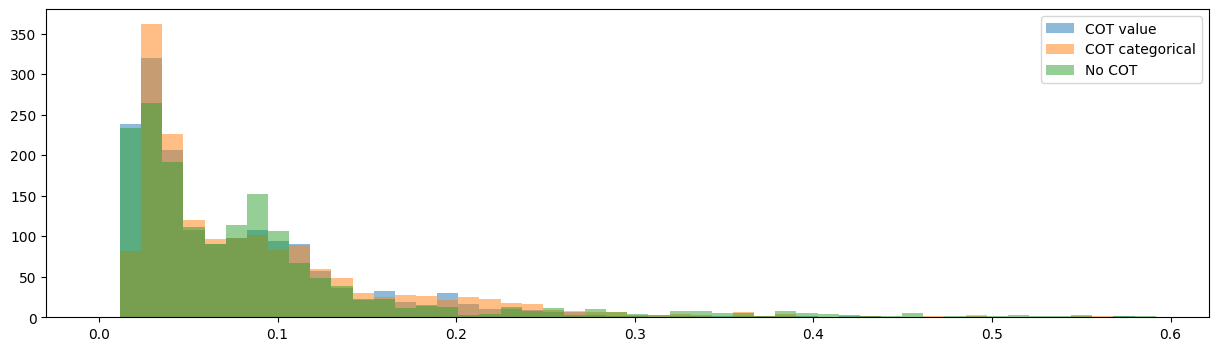

In [68]:
uncertainty_COT=y_pred_samps_sort_COT[:,2]-y_pred_samps_sort_COT[:,0]
uncertainty_cat=y_pred_samps_sort_cat[:,2]-y_pred_samps_sort_cat[:,0]
uncertainty=y_pred_samps_sort[:,2]-y_pred_samps_sort[:,0]

plt.hist(uncertainty_COT,bins=50,range=[0,np.max(np.array([np.max(uncertainty_COT),np.max(uncertainty_cat),np.max(uncertainty)]))],alpha=0.5)
plt.hist(uncertainty_cat,bins=50,range=[0,np.max(np.array([np.max(uncertainty_COT),np.max(uncertainty_cat),np.max(uncertainty)]))],alpha=0.5)
plt.hist(uncertainty,bins=50,range=[0,np.max(np.array([np.max(uncertainty_COT),np.max(uncertainty_cat),np.max(uncertainty)]))],alpha=0.5)
plt.legend(['COT value','COT categorical','No COT'])

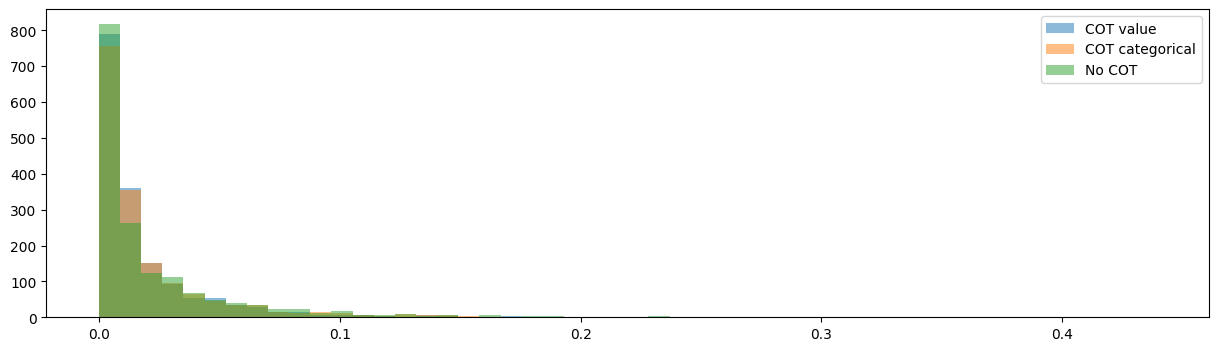

In [69]:
plt.hist(np.abs(res_COT),bins=50,
         range=[0,np.max(np.array([np.max(np.abs(res_COT)),np.max(np.abs(res))]))],
         alpha=0.5)
plt.hist(np.abs(res_cat),bins=50,
         range=[0,np.max(np.array([np.max(np.abs(res_COT)),np.max(np.abs(res_cat)),np.max(np.abs(res))]))],
         alpha=0.5)
plt.hist(np.abs(res),bins=50,
         range=[0,np.max(np.array([np.max(np.abs(res_COT)),np.max(np.abs(res_cat)),np.max(np.abs(res))]))],
         alpha=0.5)
plt.legend(['COT value','COT categorical','No COT'])

In [70]:
quant_rate_COT=QuantileNetwork.quant_rate(y_test.to_numpy()[:,0],y_preds_COT)
quant_rate_cat=QuantileNetwork.quant_rate(y_test.to_numpy()[:,0],y_preds_cat)
quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy()[:,0],y_preds)

print("Quantile rate, with COT value "+str(quant_rate_COT))
print("Quantile rate, with COT categorical: "+str(quant_rate_cat))
print("Quantile rate, without COT: "+str(quant_rate))

Quantile rate, with COT value [0.08353659 0.69085366 0.97804878]
Quantile rate, with COT categorical: [0.04756098 0.425      0.90609756]
Quantile rate, without COT: [0.08658537 0.59329268 0.95121951]
